In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as ipy

interactive(children=(IntSlider(value=0, description='i'), Output()), _dom_classes=('widget-interact',))

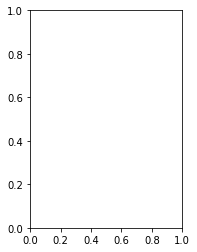

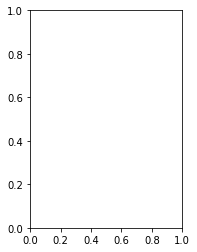

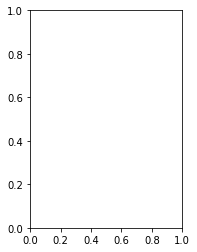

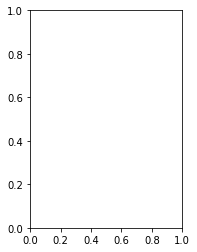

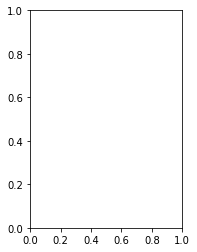

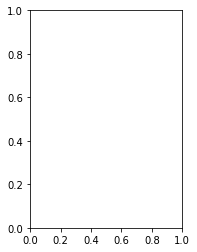

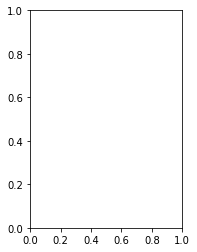

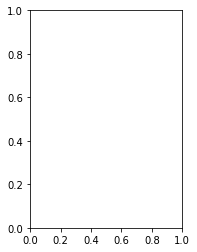

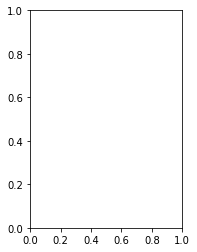

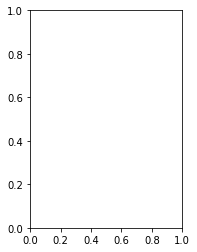

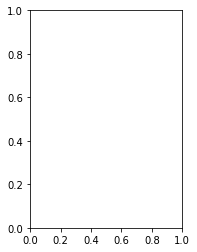

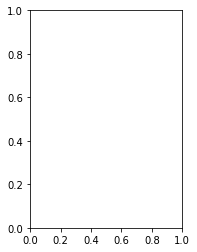

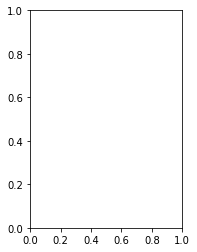

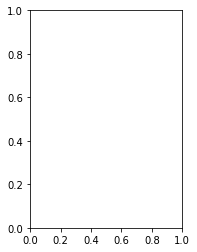

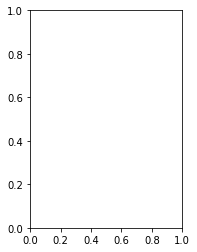

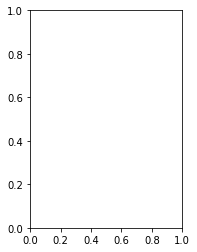

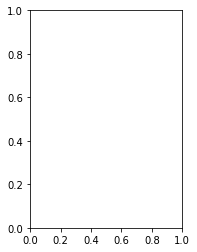

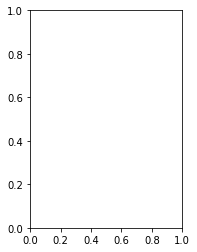

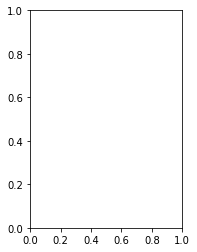

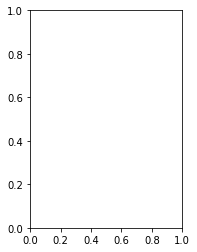

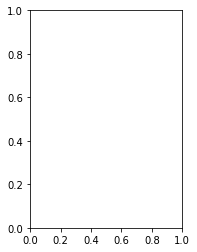

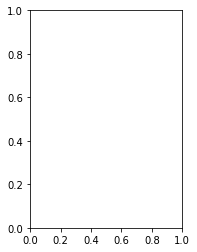

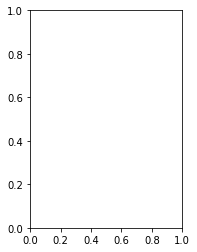

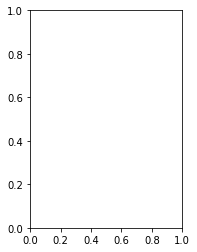

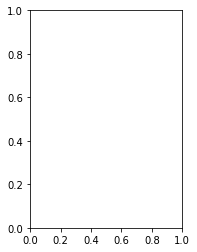

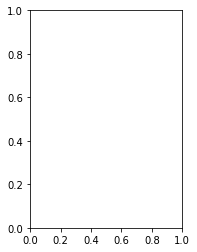

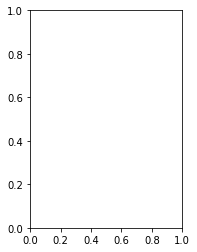

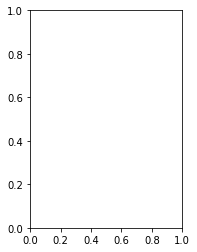

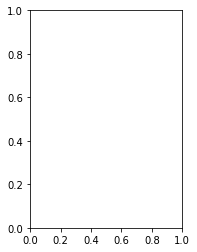

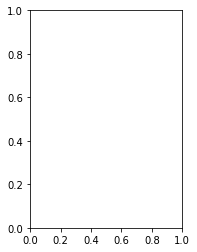

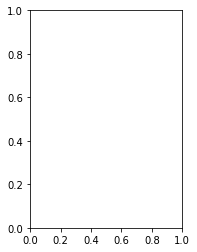

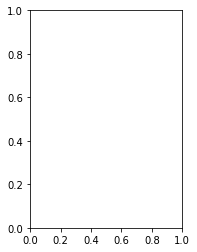

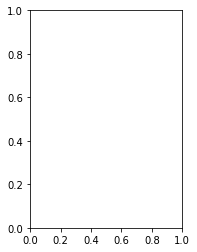

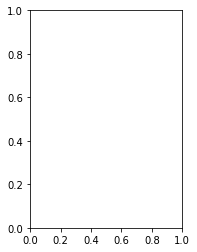

In [2]:
@ipy.interact(i=ipy.widgets.IntSlider())
def f(i):
    plt.subplot(1,2,1)
    img = plt.imread('/mnt/ml-team/dsb_2018/kuba/debug/proba_map{}.png'.format(i))
    plt.imshow(img)
    plt.subplot(1,2,2)
    img = plt.imread('/mnt/ml-team/dsb_2018/kuba/debug/binary_map{}.png'.format(i))
    plt.imshow(img)
    plt.show()